In [1]:
######################################################
#
# ReaSCAN: on the mission for AGI with language.
#
# Author: Zhengxuan Wu (wuzhengx@stanford.edu)
#
# Descriptions:
# This script is used as initial plannings for the 
# ReaSCAN engine. It illustrate how to integrate different
# parts together, such as Mini-Grid gym etc..
#
# Notes:
# 1. We will leverage gSCAN core engines but with extensive 
# modifications for ReaSCAN. This ensures fairness of 
# comparisions.
######################################################

#### gym-minigrid
This part gets you familiar with minigrid gym env

In [2]:
from collections import namedtuple
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product

from gym_minigrid.minigrid import MiniGridEnv
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import IDX_TO_OBJECT
from gym_minigrid.minigrid import OBJECT_TO_IDX
from gym_minigrid.minigrid import Circle
from gym_minigrid.minigrid import Square
from gym_minigrid.minigrid import Cylinder
from gym_minigrid.minigrid import DIR_TO_VEC
from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *

In [3]:
######################################################
# Move these to a new file probably

######################################################

In [4]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["quickly", "slowly", "while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box", "dax"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is", "which is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as", 
                    "same as", 
                    "inside of", 
                    "next to", 
                    "smaller than", 
                    "bigger than"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [5]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

In [6]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [7]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

In [8]:
class World(MiniGridEnv):
    """
    Wrapper class to execute actions in a world state. Connected to minigrid.py in gym_minigrid for visualizations.
    Every time actions are executed, the commands and situations are saved in self._observed_commands and
    self._observed_situations, which can then be retrieved with get_current_observations().
    The world can be cleared with clear_situation().
    """

    AVAILABLE_SHAPES = {"circle", "square", "cylinder", "box", "dax"}
    AVAILABLE_COLORS = {"red", "blue", "green", "yellow"}

    def __init__(self, grid_size: int, shapes: List[str], colors: List[str], object_vocabulary: ObjectVocabulary,
                 save_directory: str):
        # Some checks on the input
        for shape, color in zip(shapes, colors):
            assert shape in self.AVAILABLE_SHAPES, "Specified shape {} not implemented in minigrid env.".format(shape)
            assert color in self.AVAILABLE_COLORS, "Specified color {}, not implemented in minigrid env.".format(color)

        # Define the grid world.
        self.grid_size = grid_size

        # Column, row
        self.agent_start_pos = (0, 0)
        self.agent_start_dir = DIR_TO_INT[EAST]
        self.mission = None

        # Generate the object vocabulary.
        self._object_vocabulary = object_vocabulary
        self.num_available_objects = len(IDX_TO_OBJECT.keys())
        self.available_objects = set(OBJECT_TO_IDX.keys())

        # Data structures for keeping track of the current state of the world.
        self._placed_object_list = []
        self._target_object = None
        self._observed_commands = []
        self._observed_situations = []
        self._occupied_positions = set()
        # Hash table for looking up locations of objects based on partially formed references (e.g. find the location(s)
        # of a red cylinder when the grid has both a big red cylinder and a small red cylinder.)
        self._object_lookup_table = {}
        self.save_directory = save_directory
        super().__init__(grid_size=grid_size, max_steps=4 * grid_size * grid_size)

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height, depth=self._object_vocabulary.num_object_attributes)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            position = self.place_agent()
            self._occupied_positions.add(position)

    def initialize(self, objects: List[Tuple[Object, Position]], agent_position: Position, agent_direction: Direction,
                   target_object: PositionedObject, carrying: Object=None):
        """
        Create a grid world by placing the objects that are passed as an argument at the specified locations and the
        agent at the specified location.
        """
        self.clear_situation()
        self.agent_dir = DIR_TO_INT[agent_direction]
        self.place_agent_at(agent_position)
        self._target_object = target_object
        for current_object, current_position in objects:
            target = False
            if target_object:
                if target_object.position == current_position:
                    target = True
            self.place_object(current_object, current_position, target=target)
        if carrying:
            carrying_object = self.create_object(carrying,
                                                 self._object_vocabulary.get_object_vector(carrying.shape,
                                                                                           carrying.color,
                                                                                           carrying.size))
            self.carrying = carrying_object
            self.carrying.cur_pos = np.array([-1, -1])
            self.carrying.cur_pos = self.agent_pos

    def create_object(self, object_spec: Object, object_vector: np.ndarray, target=False):
        if object_spec.shape == "circle":
            return Circle(object_spec.color, size=object_spec.size, vector_representation=object_vector,
                          object_representation=object_spec, target=target,
                          weight=self._object_vocabulary.object_in_class(object_spec.size))
        elif object_spec.shape == "square":
            return Square(object_spec.color, size=object_spec.size, vector_representation=object_vector,
                          object_representation=object_spec, target=target,
                          weight=self._object_vocabulary.object_in_class(object_spec.size))
        elif object_spec.shape == "cylinder":
            return Cylinder(object_spec.color, size=object_spec.size, vector_representation=object_vector,
                            object_representation=object_spec,
                            weight=self._object_vocabulary.object_in_class(object_spec.size))
        else:
            raise ValueError("Trying to create an object shape {} that is not implemented.".format(object_spec.shape))

    def position_taken(self, position: Position):
        return self.grid.get(position.column, position.row) is not None

    def within_grid(self, position: Position):
        if 0 <= position.row < self.grid_size and 0 <= position.column < self.grid_size:
            return True
        else:
            return False

    def place_agent_at(self, position: Position):
        if not self.position_taken(position):
            self.place_agent(top=(position.column, position.row), size=(1, 1), rand_dir=False)
            self._occupied_positions.add((position.column, position.row))
        else:
            raise ValueError("Trying to place agent on cell that is already taken.")

    def sample_position(self) -> Position:
        available_positions = [(row, col) for row, col in itertools.product(list(range(self.grid_size)),
                                                                            list(range(self.grid_size)))
                               if (col, row) not in self._occupied_positions]
        sampled_position = random.sample(available_positions, 1).pop()
        return Position(row=sampled_position[0], column=sampled_position[1])

    def min_distance_from_edge(self, position: Position):
        row_distance = min(self.grid_size - position.row, position.row)
        column_distance = min(self.grid_size - position.column, position.column)
        return min(row_distance, column_distance)

    def sample_position_steps_from_edge(self, distance_from_edge=1) -> Position:
        available_positions = [(row, col) for row, col in itertools.product(list(range(self.grid_size)),
                                                                            list(range(self.grid_size)))
                               if (row, col) not in self._occupied_positions]
        actual_available_positions = []
        for row, col in available_positions:
            if self.min_distance_from_edge(Position(row=row, column=col)) <= distance_from_edge:
                actual_available_positions.append((row, col))
        sampled_position = random.sample(actual_available_positions, 1).pop()
        return Position(row=sampled_position[0], column=sampled_position[1])

    def sample_position_conditioned(self, north, east, south, west):
        """
        Specify for each direction how many steps should be free (i.e. before hitting wall) in that direction.
        """
        assert north == 0 or south == 0, "Can't take steps in both North and South direction"
        assert east == 0 or west == 0, "Can't take steps in both East and West direction"

        max_col = self.grid_size - east if east > 0 else self.grid_size - 1
        min_col = west - 1 if west > 0 else 0
        max_row = self.grid_size - south if south > 0 else self.grid_size - 1
        min_row = north - 1 if north > 0 else 0
        available_positions = []
        for col in range(min_col, max_col + 1):
            for row in range(min_row, max_row + 1):
                available_positions.append((row, col))
        sampled_position = random.sample(available_positions, 1).pop()
        return Position(row=sampled_position[0], column=sampled_position[1])

    def place_object(self, object_spec: Object, position: Position, target=False):
        if not self.within_grid(position):
            raise IndexError("Trying to place object '{}' outside of grid of size {}.".format(
                object_spec.shape, self.grid_size))
        # Object already placed at this location
        if self.position_taken(position):
            print("WARNING: attempt to place two objects at location ({}, {}), but overlapping objects not "
                  "supported. Skipping object.".format(position.row, position.column))
        else:
            object_vector = self._object_vocabulary.get_object_vector(shape=object_spec.shape, color=object_spec.color,
                                                                      size=object_spec.size)
            positioned_object = PositionedObject(object=object_spec, position=position, vector=object_vector)
            self.place_obj(self.create_object(object_spec, object_vector, target=target),
                           top=(position.column, position.row), size=(1, 1))

            # Add to list that keeps track of all objects currently positioned on the grid.
            self._placed_object_list.append(positioned_object)

            # Adjust the object lookup table accordingly.
            self._add_object_to_lookup_table(positioned_object)

            # Add to occupied positions:
            self._occupied_positions.add((position.column, position.row))

            if target:
                self._target_object = positioned_object

    def _add_object_to_lookup_table(self, positioned_object: PositionedObject):
        object_size = positioned_object.object.size
        object_color = positioned_object.object.color
        object_shape = positioned_object.object.shape

        # Generate all possible names
        object_names = generate_possible_object_names(color=object_color, shape=object_shape)
        for possible_object_name in object_names:
            if possible_object_name not in self._object_lookup_table.keys():
                self._object_lookup_table[possible_object_name] = {}

            # This part allows for multiple exactly the same objects (e.g. 2 small red circles) to be on the grid.
            if positioned_object.object.size not in self._object_lookup_table[possible_object_name].keys():
                self._object_lookup_table[possible_object_name] = {
                    size: [] for size in self._object_vocabulary.object_sizes}
            self._object_lookup_table[possible_object_name][object_size].append(
                positioned_object.position)

    def _remove_object(self, target_position: Position) -> PositionedObject:
        # remove from placed_object_list
        target_object = None
        for i, positioned_object in enumerate(self._placed_object_list):
            if positioned_object.position == target_position:
                target_object = self._placed_object_list[i]
                del self._placed_object_list[i]
                break

        # remove from object_lookup Table
        self._remove_object_from_lookup_table(target_object)

        # remove from gym grid
        self.grid.get(target_position.column, target_position.row)
        self.grid.set(target_position.column, target_position.row, None)

        self._occupied_positions.remove((target_position.column, target_position.row))

        return target_object

    def _remove_object_from_lookup_table(self, positioned_object: PositionedObject):
        possible_object_names = generate_possible_object_names(positioned_object.object.color,
                                                               positioned_object.object.shape)
        for possible_object_name in possible_object_names:
            self._object_lookup_table[possible_object_name][positioned_object.object.size].remove(
                positioned_object.position)

    def move_object(self, old_position: Position, new_position: Position):
        # Remove object from old position
        old_positioned_object = self._remove_object(old_position)
        if not old_positioned_object:
            raise ValueError("Trying to move an object from an empty grid location (row {}, col {})".format(
                old_position.row, old_position.column))

        # Add object at new position
        self.place_object(old_positioned_object.object, new_position)

    def pull(self, position: Position):
        self.agent_pos = (position.column, position.row)
        self._observed_commands.append("pull")
        self._observed_situations.append(self.get_current_situation())

    def pick_up_object(self):
        """
        Picking up an object in gym-minigrid means removing it and saying the agent is carrying it.
        :return:
        """
        assert self.grid.get(*self.agent_pos) is not None, "Trying to pick up an object at an empty cell."
        self.step(self.actions.pickup)
        if self.carrying:
            self._remove_object(Position(column=self.agent_pos[0], row=self.agent_pos[1]))
            self._observed_commands.append("PICK UP")
            self._observed_situations.append(self.get_current_situation())

    def drop_object(self):
        assert self.carrying is not None, "Trying to drop something but not carrying anything."
        self.place_object(self.carrying.object_representation, Position(column=self.agent_pos[0],
                                                                        row=self.agent_pos[1]))
        self.carrying = None
        self._observed_commands.append("DROP")
        self._observed_situations.append(self.get_current_situation())

    def push_or_pull_object(self, direction: Direction, primitive_command: str):
        current_object = self.grid.get(*self.agent_pos)
        if not current_object:
            self._observed_commands.append(primitive_command)
            self._observed_situations.append(self.get_current_situation())
        else:
            assert current_object.can_push(), "Trying to push an object that cannot be pushed"
            if current_object.push():
                new_position = self.agent_pos + DIR_TO_VEC[DIR_TO_INT[direction]]
                new_position = Position(column=new_position[0], row=new_position[1])
                # If the new position isn't occupied by another object, push it forward.
                if self.within_grid(new_position):
                    if not self.grid.get(new_position[0], new_position[1]):
                        self.move_object(Position(column=self.agent_pos[0], row=self.agent_pos[1]), new_position)
                        if primitive_command == "push":
                            self.take_step_in_direction(direction, primitive_command)
                        else:
                            self.pull(position=new_position)

            else:
                # Pushing an object that won't move just yet (because it's heavy).
                self._observed_commands.append(primitive_command)
                self._observed_situations.append(self.get_current_situation())

    def move_object_to_wall(self, action: str, manner: str):
        if action == "push":
            direction = INT_TO_DIR[self.agent_dir]
        else:
            direction = INT_TO_DIR[(self.agent_dir + 2) % 4]
        while self.empty_cell_in_direction(direction=direction):
            if manner == "while spinning":
                self.spin()
            elif manner == "cautiously":
                self.look_left_and_right()
            self.push_or_pull_object(direction=direction, primitive_command=action)
            if manner == "hesitantly":
                self.hesitate()

    @staticmethod
    def get_direction(direction_str: str):
        return DIR_STR_TO_DIR[direction_str]

    @staticmethod
    def get_position_at(current_position: Position, direction_str: str, distance: int) -> Position:
        """Returns the column and row of a position on the grid some distance away in a particular direction."""
        assert len(DIR_STR_TO_DIR[direction_str]) == 1, "getting a position at a distance only implemented for "\
                                                        "straight directions"
        direction = DIR_STR_TO_DIR[direction_str]
        direction_vec = DIR_TO_VEC[DIR_TO_INT[direction]] * distance
        position = np.array([current_position.column, current_position.row]) + direction_vec
        return Position(column=position[0], row=position[1])

    def direction_to_goal(self, goal: Position):
        difference_vec = np.array([goal.column - self.agent_pos[0], goal.row - self.agent_pos[1]])
        difference_vec[difference_vec < 0] = 0
        col_difference = difference_vec[0]
        row_difference = difference_vec[1]
        if col_difference and row_difference:
            return "SE", self.actions.left
        elif col_difference and not row_difference:
            return "NE", self.actions.right
        elif row_difference and not col_difference:
            return "SW", self.actions.right
        else:
            return "NW", self.actions.left

    def execute_command(self, command_str: str):
        command_list = command_str.split()
        verb = command_list[0]
        if len(command_list) > 1 and verb == "turn":
            direction = command_list[1]
            if direction == "left":
                self.take_step(self.actions.left, "turn left")
            elif direction == "right":
                self.take_step(self.actions.right, "turn right")
            else:
                raise ValueError("Trying to turn in an unknown direction")
        elif verb == "walk" or verb == "run" or verb == "jump":
            self.take_step_in_direction(direction=DIR_STR_TO_DIR[INT_TO_DIR[self.agent_dir].name[0]],
                                        primitive_command=verb)
        elif verb == "push" or verb == "pull":
            self.push_or_pull_object(direction=DIR_STR_TO_DIR[INT_TO_DIR[self.agent_dir].name[0]],
                                     primitive_command=verb)
        elif verb == "stay":
            return
        else:
            raise ValueError("Incorrect command {}.".format(command_str))

    def empty_cell_in_direction(self, direction: Direction):
        next_cell = self.agent_pos + DIR_TO_VEC[DIR_TO_INT[direction]]
        if self.within_grid(Position(column=next_cell[0], row=next_cell[1])):
            next_cell_object = self.grid.get(*next_cell)
            return not next_cell_object
        else:
            return False

    def look_left_and_right(self):
        self.take_step(self.actions.left, "turn left")
        self.take_step(self.actions.right, "turn right")
        self.take_step(self.actions.right, "turn right")
        self.take_step(self.actions.left, "turn left")

    def hesitate(self):
        self._observed_commands.append("stay")
        self._observed_situations.append(self.get_current_situation())

    def spin(self):
        for _ in range(4):
            self.take_step(self.actions.left, "turn left")

    def move_with_manners(self, direction: Direction, manner: str, primitive_command: str):
        # Spin to the left
        if manner == "while spinning":
            self.spin()
            self.take_step_in_direction(direction=direction, primitive_command=primitive_command)
        # Look left and right if cautious
        elif manner == "cautiously":
            self.turn_to_direction(direction=direction)
            self.look_left_and_right()
            self.take_step_in_direction(direction=direction, primitive_command=primitive_command)
        else:
            self.take_step_in_direction(direction=direction, primitive_command=primitive_command)

        # Stop after each step
        if manner == "hesitantly":
            self.hesitate()

    def go_to_position(self, position: Position, manner: str, primitive_command: str):
        """Move to the position denoted in the argument. Adds an action for each step to self._observed_commands
        and self._observed_situations. If a manner is specified, the sequence of actions will be transformed to
        represent the specified manner."""
        # Zigzag somewhere until in line with the goal, then just go straight for the goal
        if manner == "while zigzagging" and not self.agent_in_line_with_goal(position):
            # Find direction of goal.
            direction_to_goal, first_move = self.direction_to_goal(position)
            previous_step = first_move
            if direction_to_goal == "NE" or direction_to_goal == "SE":
                self.take_step_in_direction(direction=EAST, primitive_command=primitive_command)
            else:
                self.take_step_in_direction(direction=WEST, primitive_command=primitive_command)
            while not self.agent_in_line_with_goal(position):
                # turn in opposite direction of previous step and take take step
                if previous_step == self.actions.left:
                    self.take_step(self.actions.right, "turn right")
                    previous_step = self.actions.right
                else:
                    self.take_step(self.actions.left, "turn left")
                    previous_step = self.actions.left
                self.take_step(self.actions.forward, primitive_command)

            # Finish the route not zigzagging
            while self.agent_pos[0] > position.column:
                self.take_step_in_direction(direction=WEST, primitive_command=primitive_command)
            while self.agent_pos[0] < position.column:
                self.take_step_in_direction(direction=EAST, primitive_command=primitive_command)
            while self.agent_pos[1] > position.row:
                self.take_step_in_direction(direction=NORTH, primitive_command=primitive_command)
            while self.agent_pos[1] < position.row:
                self.take_step_in_direction(direction=SOUTH, primitive_command=primitive_command)
        else:
            # Calculate the route to the object on the grid.
            while self.agent_pos[0] > position.column:
                self.move_with_manners(direction=WEST, manner=manner, primitive_command=primitive_command)
            while self.agent_pos[0] < position.column:
                self.move_with_manners(direction=EAST, manner=manner, primitive_command=primitive_command)
            while self.agent_pos[1] > position.row:
                self.move_with_manners(direction=NORTH, manner=manner, primitive_command=primitive_command)
            while self.agent_pos[1] < position.row:
                self.move_with_manners(direction=SOUTH, manner=manner, primitive_command=primitive_command)

    def has_object(self, object_str: str) -> bool:
        if object_str not in self._object_lookup_table.keys():
            return False
        else:
            return True

    def object_positions(self, object_str: str, object_size=None) -> List[Position]:
        assert self.has_object(object_str), "Trying to get an object's position that is not placed in the world."
        object_locations = self._object_lookup_table[object_str]
        if object_size:
            present_object_sizes = [size for size, objects in object_locations.items() if objects]
            present_object_sizes.sort()
            assert len(present_object_sizes) >= 2, "referring to a {} object but only one of its size present.".format(
                object_size)
            # Perhaps just keep track of smallest and largest object in world
            if object_size == "small":
                object_locations = object_locations[present_object_sizes[0]]
            elif object_size == "big":
                object_locations = object_locations[present_object_sizes[-1]]
            else:
                raise ValueError("Wrong size in term specifications.")
        else:
            object_locations = object_locations.items()
        return object_locations

    def agent_in_line_with_goal(self, goal: Position):
        return goal.column == self.agent_pos[0] or goal.row == self.agent_pos[1]

    def take_step(self, action, observed_command: str):
        self.step(action=action)
        self._observed_situations.append(self.get_current_situation())
        self._observed_commands.append(observed_command)

    def turn_to_direction(self, direction: Direction) -> {}:
        """Turn to some direction."""
        current_direction = self.agent_dir
        target_direction = DIR_TO_INT[direction]
        if current_direction == target_direction:
            return
        assert current_direction != target_direction, "Trying to turn to a direction that is the current direction."
        difference_vector = DIR_TO_VEC[target_direction] - DIR_TO_VEC[self.agent_dir]
        difference_norm = np.linalg.norm(difference_vector, ord=2)
        if difference_norm >= 2:
            self.take_step(self.actions.left, "turn left")
            self.take_step(self.actions.left, "turn left")
        else:
            if current_direction == 0:  # East
                if target_direction == 1:
                    self.take_step(self.actions.right, "turn right")
                else:
                    self.take_step(self.actions.left, "turn left")
            elif current_direction == 3:  # North
                if target_direction == 0:
                    self.take_step(self.actions.right, "turn right")
                else:
                    self.take_step(self.actions.left, "turn left")
            else:  # South and West
                if target_direction > current_direction:
                    self.take_step(self.actions.right, "turn right")
                else:
                    self.take_step(self.actions.left, "turn left")

    def take_step_in_direction(self, direction: Direction, primitive_command: str):
        """
        Turn to some direction and take a step forward.
        """
        if DIR_TO_INT[direction] != self.agent_dir:
            self.turn_to_direction(direction)
        if self.within_grid(Position(column=self.front_pos[0], row=self.front_pos[1])):
            self.step(action=self.actions.forward)
            self._observed_commands.append(primitive_command)
            self._observed_situations.append(self.get_current_situation())

    def save_situation(self, file_name, attention_weights=[]) -> str:
        save_location = os.path.join(self.save_directory, file_name)
        assert save_location.endswith('.png'), "Invalid file name passed to save_situation, must end with .png."
        success = self.render(mode="human", attention_weights=attention_weights).save(save_location)
        if not success:
            print("WARNING: image with name {} failed to save.".format(file_name))
            return ''
        else:
            return save_location

    def get_current_situation_image(self) -> np.ndarray:
        return self.render().getArray()

    def get_current_situation_grid_repr(self) -> np.ndarray:
        return self.grid.encode(agent_row=self.agent_pos[1], agent_column=self.agent_pos[0],
                                agent_direction=self.agent_dir)

    def save_current_situation_image(self, image_name: str):
        save_path = os.path.join(self.save_directory, image_name)
        current_situation_array = self.get_current_situation_image()
        numpy_array_to_image(current_situation_array, save_path)

    def get_current_situation(self) -> Situation:
        if self.carrying:
            carrying = self.carrying.object_representation
        else:
            carrying = None
        return Situation(grid_size=self.grid_size,
                         agent_position=Position(column=self.agent_pos[0], row=self.agent_pos[1]),
                         target_object=self._target_object,
                         agent_direction=INT_TO_DIR[self.agent_dir], placed_objects=self._placed_object_list.copy(),
                         carrying=carrying)

    def get_current_observations(self):
        return self._observed_commands.copy(), self._observed_situations.copy()

    def clear_situation(self):
        self._object_lookup_table.clear()
        self._placed_object_list.clear()
        self._observed_commands.clear()
        self._observed_situations.clear()
        self._occupied_positions.clear()
        self.reset()

    def set_mission(self, mission: str):
        self.mission = mission


In [16]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'
world = World(grid_size=4, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world_rgb = world.render("rgb_array")

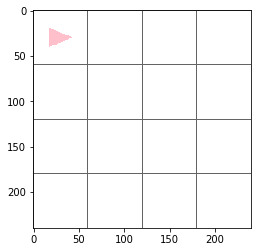

In [17]:
plt.imshow(world_rgb)
plt.show()

In [19]:
world_rgb.shape

(240, 240, 3)